In [2]:
from wiki import WikiCorpus, PICKLE_FILE, CORPUS_DIR
from tqdm import tqdm

try:
    corpus = WikiCorpus.from_pickle(PICKLE_FILE)
except FileNotFoundError:
    corpus = WikiCorpus.from_corpus_files()
    corpus.generate_network('all_users', normalize_edge_weights=False)
    corpus.to_pickle(PICKLE_FILE)

Opening pickle...


  0%|          | 0/389121 [00:00<?, ?it/s]

Loading users...
Loading posts...


  4%|▍         | 14674/389121 [00:00<00:02, 143142.05it/s]

Setting up corpus...


100%|██████████| 389121/389121 [00:01<00:00, 217617.86it/s]


In [ ]:
import networkx as nx
net = corpus.networks['all_users']
eigen = nx.eigenvector_centrality_numpy(net)
for user in corpus.users.values():
    user.data['eigenvector_centrality'] = eigen[user.id] if user.id in eigen else None


# Calculate coordination measures

For a user $b$ and a group of users $A$, let $S^A_b$ be the set of pairs of utterances $(u_a, u_b)$ where $u_b$ is utterd by $b$ in reply to the parent utterance $u_a$, uttered by $a \in A$ 

$\mathcal{E}_m(u)$ means that utterance $u$ exhibits some linguistic marker, $m$.

Following *Echoes of Power* we define the coordination of user $b$ towards a group $A$ (the *coordination given* by $b$) as follows:
$$
C^g_m(A,b) = P\big[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a) \land (u_a, u_b) \in S^A_b\big] -
P\big[\mathcal{E}_m(u_b) \mid (u_a, u_b) \in S^A_b\big]
$$

The probabilities are estimated by counting occurances of $m$ in $S^A_b$:

$$
C^g_m(A,b) \approx \sum_{(u_a,u_b)\in S^A_b}\Big({
\frac{[\mathcal{E}_m(u_a) \land \mathcal{E}_m(u_b)]}{[\mathcal{E}_m(u_a)]} - 
\frac{[\mathcal{E}_m(u_b)]}{1}}  \Big)
$$

$C^m(A,b)$ is defined for $m$, $b$ and $A$ where $b$ where $\{(u_a, u_b) \in S^A_b \mid \mathcal{E}_m(u_a)\} \neq \varnothing $.

Likewise, we estimate the coordination of a group $A$ towards a user $b$ (the *coordination received* by $b$) as:

$$
C^r_m(A,b) \approx \sum_{(u_b,u_a)\in S^b_A}\Big({
\frac{[\mathcal{E}_m(u_b) \land \mathcal{E}_m(u_a)]}{[\mathcal{E}_m(u_b)]} - 
\frac{[\mathcal{E}_m(u_a)]}{1}}  \Big)
$$

where $S^b_A$ is the set of pairs of utterances where a member of group $A$ is replying to an utteance of user $b$ (note that this is an entirely distinct set from $S^A_b$).

As before, $C^r_m(A,b)$ is defined if $\{(u_b, u_a) \in S^b_A \mid \mathcal{E}_m(u_b)\} \neq \varnothing $

In both cases, to aggregate over markers, we take the average of the marker-specific coordination measures for which $C^*_m(A,b)$ is defined.

In [ ]:
from collections import defaultdict, Counter
from util import get_lines

markers = ['conjunctions', 'articles', 'prepositions', 'adverbs', 'quantifiers',
            'impersonal pronouns', 'personal pronouns', 'auxiliary verbs']

# coordination given counts - counting over pairs 
# (u_a, u_b) where a in A said u_a and b replied with u_b
Am_bm = defaultdict(Counter) # count u_a and u_b exhibit m 
Am_b  = defaultdict(Counter) # count u_a exhibits m
A_bm  = defaultdict(Counter) # count u_b exhibits m
A_b   = Counter() # count total number of reply pairs (u_a, u_b)

# coordination received counts - counting over pairs
# (u_b, u_a) where b said u_b and a in A replied with u_a
bm_Am = defaultdict(Counter) # count u_b and u_a exhibit m 
bm_A  = defaultdict(Counter) # count u_b exhibits m
b_Am  = defaultdict(Counter) # count u_a exhibits m
b_A   = Counter() # count total number of reply pairs (u_b, u_a)

def calculate_coordination(A):
    """
    Calculates the coordination users give to / receive from users in group A
    """
    for reply in tqdm(corpus.posts.values()):
        reply_user = reply.get_author()
        parent = reply.get_parent()
        parent_user = parent.get_author() if parent else None
        if reply_user and parent_user:
            reply_user = reply_user.id
            parent_user = parent_user.id
        else:
            continue
        if parent_user in A: # increment coordination given counts
            A_b[reply_user] += 1
            for m in markers:
                if parent.exhibits_marker(m):
                    Am_b[reply_user][m] += 1
                    if reply.exhibits_marker(m):
                        Am_bm[reply_user][m] += 1
                if reply.exhibits_marker(m):
                    A_bm[reply_user][m] += 1
        if reply_user in A: # increment coordination received counts
            b_A[parent_user] += 1
            for m in markers:
                if parent.exhibits_marker(m):
                    bm_A[parent_user][m] += 1
                    if reply.exhibits_marker(m):
                        bm_Am[parent_user][m] += 1
                if reply.exhibits_marker(m):
                    b_Am[parent_user][m] += 1
    coord_given = {b: {m:
        (Am_bm[b][m] / Am_b[b][m]) - (A_bm[b][m] / A_b[b]) 
        if Am_b[b][m] > 0 else None 
        for m in markers} for b in corpus.users} 
    coord_received = {b: {m:
        (bm_Am[b][m] / bm_A[b][m]) - (b_Am[b][m] / b_A[b])
        if bm_A[b][m] > 0 else None 
        for m in markers} for b in corpus.users}

    return coord_given, coord_received

print('Caluclating universal coordination given/received...')
coord_given_universal, coord_received_universal = calculate_coordination(corpus.users.keys())
for user in corpus.users.values():
    coord_given = coord_given_universal[user.id]
    coord_received = coord_received_universal[user.id]
    for m in markers:
        user.data['coord_given_univ' + m] = coord_given[m]
        user.data['coord_received_univ' + m] = coord_received[m]
    given_defined = [coord_given[m] for m in markers if coord_given[m] is not None]
    received_defined = [coord_received[m] for m in markers if coord_received[m] is not None]
    user.data['coord_given_univ_agg'] = sum(given_defined) / len(given_defined) if given_defined else None

    user.data['coord_received_univ_agg'] = sum(received_defined) / len(received_defined) if received_defined else None

In [ ]:
for post in corpus.posts.values():
    post.data['bold'] = False
    post.data['italics'] = False
    post.data['link'] = False
    if re.search("''''.+''''", post.clean_text):
        post.data['bold'] = True
        post.data['italics'] = True
    elif re.search("'''.+'''''", post.clean_text):
        post.data['bold'] = True
    elif re.search("''.+''", post.clean_text):
        post.data['italics'] = True
    if re.search("[[.+]]", post.clean_text):
        post.data['link'] = True

In [ ]:
for user in corpus.users.values():
    posts = user.get_posts(None)
    italics_posts = [post for post in posts if post.data['italics']]
    bold_posts = [post for post in posts if post.data['bold']]
    link_posts = [post for post in posts if post.data['link']]
    user.data['italics_usage'] = len(italics_posts) / len(posts) if posts else None
    user.data['bold_usage'] = len(italics_posts) / len(posts) if posts else None
    user.data['link_usage'] = len(link_posts) / len(posts) if posts else None
    user.data['avg_post_length'] = sum(len(post.tokens) for post in posts) / len(posts) if posts else None
    user.data['n_posts'] = len(posts)

365

In [13]:
import networkx as nx
import community # https://github.com/taynaud/python-louvain
g = corpus.generate_network('all_users', normalize_edge_weights=False)


  0%|          | 1748/389121 [00:00<00:22, 17069.67it/s]

Generating network ...


100%|██████████| 389121/389121 [00:01<00:00, 196328.36it/s]


There were 30356 posts to/from unknown users.
The unpruned network has  22495 nodes.
Pruning network to its largest component...
	 removed 398 users from 192 disconnected components.


In [16]:
partition = community.best_partition(g)

In [70]:
g_clusters = nx.Graph()
g_clusters.add_nodes_from(set(partition.values()), weight=0)
for user in g.nodes():
    g_clusters.node[partition[user]]['weight'] += 1

In [71]:
for (u, v), weight in nx.get_edge_attributes(g, 'weight').items():
    u, v = partition[u], partition[v]
    if not g_clusters.has_edge(u, v):
        g_clusters.add_edge(u, v, weight=weight)
    else:
        g_clusters.edge[u][v]['weight'] += weight

In [91]:
nodes = nx.get_node_attributes(g_clusters, 'weight').items()
edges = nx.get_edge_attributes(g_clusters, 'weight').items()
edges = [((u,v), w) for (u,v), w in edges if w >= 100]

nodes, node_weights = zip(*nodes)
edges, edge_weights = zip(*edges)

node_weights = [w / max(node_weights) * 300 for w in node_weights]
edge_weights = [w / max(edge_weights) * 2 for w in edge_weights]

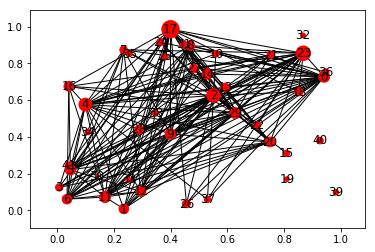

In [92]:
%matplotlib inline

import matplotlib.pyplot as plt

pos = nx.random_layout(g_clusters)
nx.draw_networkx_nodes(g_clusters, pos, nodes, node_size=node_weights)
nx.draw_networkx_labels(g_clusters, pos)
nx.draw_networkx_edges(g_clusters, pos, edgelist=edges)

plt.draw()


In [94]:
len(g.nodes()) + len(g.edges())

88519

In [ ]:
data_fields = ['coord_given_univ_agg', 'coord_received_univ_agg', 'eigenvector_centrality',
              'italics_usage', 'bold_usage', 'link_usage', 'avg_post_length', 'n_posts']
corpus.export_user_data(data_fields, CORPUS_DIR + 'user_data.csv')